# LSTM for Time Series Analysis

We will use the **LSTM RNN** for forecasting Bitcoin trade data. We take in sequence of previous data with all dimensions and predict the *High* value. 

In [298]:
import sklearn.preprocessing as sk

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

False


First read the data and preview

In [299]:
training_set = pd.read_csv('../data/gemini_BTCUSD_day.csv')
training_set.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1642737600000,2022-01-21 04:00:00,BTCUSD,38462.49,39289.82,35389.69,36356.59,3462.668751
1,1642651200000,2022-01-20 04:00:00,BTCUSD,41954.50,43516.85,38260.00,38462.49,2551.473106
2,1642564800000,2022-01-19 04:00:00,BTCUSD,41712.63,42580.05,41156.28,41954.50,1214.411904
3,1642478400000,2022-01-18 04:00:00,BTCUSD,42052.76,42679.80,41281.06,41712.63,1130.901551
4,1642392000000,2022-01-17 04:00:00,BTCUSD,42655.12,42976.61,41559.11,42052.76,636.137418


## Pre-processing the data

In [300]:
training_set = training_set[['Open', 'High', 'Low', 'Close','Volume']]

# Appropriate scaling to avoid large values
x_scaler = sk.MinMaxScaler(feature_range = (0, 1))
y_scaler = sk.MinMaxScaler(feature_range = (0, 1))

# Transforming into standardized data
x_data = x_scaler.fit_transform(training_set)
y_data = y_scaler.fit_transform(training_set[['High']])

training_set.head()

,Open,High,Low,Close,Volume
0,38462.49,39289.82,35389.69,36356.59,3462.668751
1,41954.50,43516.85,38260.00,38462.49,2551.473106
2,41712.63,42580.05,41156.28,41954.50,1214.411904
3,42052.76,42679.80,41281.06,41712.63,1130.901551
4,42655.12,42976.61,41559.11,42052.76,636.137418


We define our own `Dataset` for convenience

In [301]:
class MyDset(Dataset):

    def __init__(self, data, target, window, horizon=0):
        x_vals = []
        y_vals = []
        start = 0 + window 
        end = len(data) - horizon

        for i in range(start, end):
            x = data[(i-window):i,:]
            y = target[i:(i+horizon),:]
            x_vals.append(x)
            y_vals.append(y)

        tensor_x = torch.Tensor(x_vals)
        tensor_y = torch.Tensor(y_vals)

        self.data = tensor_x
        self.target = tensor_y.flatten(1)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

We create the `Dataloader` objects. We will reserve the `loader_test` for later.

In [302]:
horizon = 1
set_train = MyDset(x_data, y_data, window=100, horizon = horizon)
batch_size = 20
train_split = int(0.8*(len(set_train)))

loader_train = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split)))
   
loader_test = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split, len(set_train))))

Debugging

In [303]:
for t, (x,y) in enumerate(loader_train):
    print(x.shape)
    print(y[0])
    break

torch.Size([20, 100, 5])
tensor([0.2790])


## Implementing the model

We use **LSTM** recurrent neural network with a fully connected layer.

In [304]:
class RNN(nn.Module):
    '''Implement the LSTM model for forecasting.'''
    def __init__(self, input_size, hidden_size, \
        num_layer, num_class = 1):

        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_class = num_class

        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, \
            batch_first = True) # initial hidden and cell state default 0

        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, input):
        
        _out , (h_out, _) = self.lstm(input) # output of LSTM is out,(hidden,cell)

        r = h_out.view(-1, self.hidden_size) # reshape to use linear for prediction

        output = self.fc(r)

        return output

Testing and debugging

In [305]:
x = torch.zeros([20,100,5])
input_size = 5
hidden_size = 10
num_layer = 1
num_class = horizon

model = RNN(input_size, hidden_size, num_layer, num_class)
model(x).shape

torch.Size([20, 1])

# Training

We train with *mean squared error* loss and optimizer *Adam*

In [306]:
input_size = 5
hidden_size = 10
num_layer = 1
num_class = horizon
model = RNN(input_size, hidden_size, num_layer, num_class)


learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20

In [307]:
print_every = 100
for e in range(epochs):

    for t, (x,y) in enumerate(loader_train):

        model.train()  # put model to training mode

        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32)

        scores = model(x)
        
        loss = criterion(scores, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if t % print_every == 0:
            print('Epoch %d Iteration %d, loss = %.8f' % (e, t, loss.item()))
            print(t)

torch.save(model.state_dict(), 'LSTM.ckpt')

Epoch 0 Iteration 0, loss = 0.11115764
0
Epoch 1 Iteration 0, loss = 0.00010337
0
Epoch 2 Iteration 0, loss = 0.00003006
0
Epoch 3 Iteration 0, loss = 0.00021940
0
Epoch 4 Iteration 0, loss = 0.00015896
0
Epoch 5 Iteration 0, loss = 0.00029795
0
Epoch 6 Iteration 0, loss = 0.00003157
0
Epoch 7 Iteration 0, loss = 0.00017528
0
Epoch 8 Iteration 0, loss = 0.00002315
0
Epoch 9 Iteration 0, loss = 0.00019467
0
Epoch 10 Iteration 0, loss = 0.00083331
0
Epoch 11 Iteration 0, loss = 0.00031066
0
Epoch 12 Iteration 0, loss = 0.00008946
0
Epoch 13 Iteration 0, loss = 0.00013476
0
Epoch 14 Iteration 0, loss = 0.00015899
0
Epoch 15 Iteration 0, loss = 0.00004319
0
Epoch 16 Iteration 0, loss = 0.00002169
0
Epoch 17 Iteration 0, loss = 0.00017866
0
Epoch 18 Iteration 0, loss = 0.00015308
0
Epoch 19 Iteration 0, loss = 0.00007225
0


# Testing

We provide an example to visualize this

In [308]:
test = []
test_x = None
test_y = None
for (x,y) in loader_test:
    test.append((x,y))
print(len(test))

test_x, test_y = test[9]
print(test_x)

22
tensor([[[5.4517e-03, 1.8967e-03, 5.5737e-03, 1.8878e-03, 1.8985e-02],
         [5.4610e-03, 1.9488e-03, 5.5768e-03, 1.9036e-03, 1.6985e-02],
         [5.5389e-03, 1.9635e-03, 5.5328e-03, 1.9129e-03, 4.2013e-03],
         ...,
         [4.3543e-03, 9.3084e-04, 4.5030e-03, 9.2835e-04, 2.2248e-02],
         [4.2566e-03, 7.8540e-04, 4.3543e-03, 8.0226e-04, 1.2010e-02],
         [4.1590e-03, 7.5616e-04, 4.2858e-03, 7.0428e-04, 8.8707e-03]],

        [[1.8628e-02, 1.5184e-02, 1.9242e-02, 1.5257e-02, 6.0780e-02],
         [1.8460e-02, 1.5053e-02, 1.8792e-02, 1.5127e-02, 3.3188e-02],
         [1.8752e-02, 1.5170e-02, 1.8729e-02, 1.4959e-02, 3.0877e-02],
         ...,
         [1.0711e-02, 7.1320e-03, 1.1045e-02, 7.1802e-03, 3.8158e-02],
         [1.0697e-02, 7.1209e-03, 1.0938e-02, 7.1818e-03, 4.7482e-02],
         [1.0671e-02, 7.1121e-03, 1.0992e-02, 7.1672e-03, 2.4971e-02]],

        [[5.6071e-03, 2.0575e-03, 5.7296e-03, 2.0064e-03, 3.2064e-03],
         [5.4121e-03, 2.1068e-03, 5.3321e-

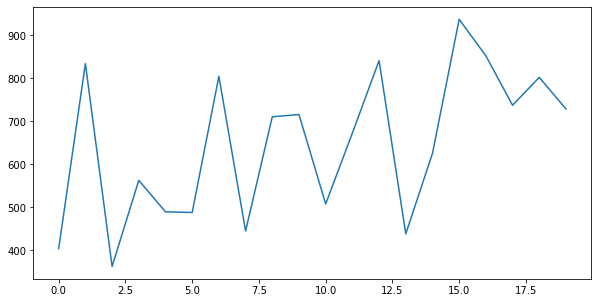

In [309]:
model.eval()

predicted = model(test_x).data.numpy()
predicted = y_scaler.inverse_transform(predicted)
# with torch.no_grad():
#     predicted = y_scaler.inverse_transform(predicted)[0]
#     test_y = y_scaler.inverse_transform(test_y)[0]

plt.figure(figsize=(10,5))
plt.plot(predicted)


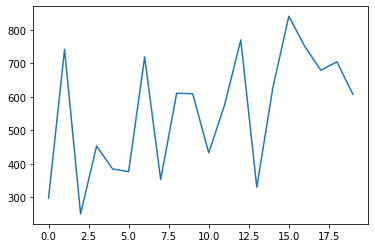

In [310]:
test_y = y_scaler.inverse_transform(test_y)
plt.plot(test_y)

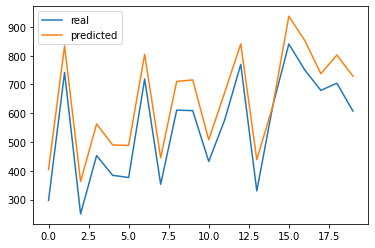

In [311]:
plt.plot(test_y, label="real")
plt.plot(predicted, label="predicted")
plt.legend()


In [313]:
input_size = 5
hidden_size = 10
num_layer = 1
num_class = horizon
model = RNN(input_size, hidden_size, num_layer, num_class)

model.load_state_dict(torch.load("..\src\LSTM.ckpt"))

<All keys matched successfully>